In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import scipy.misc
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
#import essentia, essentia.standard as ess

In [3]:
def chargen(char=20):
    print char
    char_gen = []
    i=0
    genre={}
    cont=0
    for folder in os.listdir("./genres"): #iterates all folders    

        folder="./genres/"+folder
        if not folder in genre.keys(): #creates a dictionary genre->number
            genre[folder]=i
            i+=1

        for filename in os.listdir(folder): #iterates all files in the folder
            filename = folder+"/"+filename

            if filename.endswith((".au",".mp3",".wav",".aiff")):
                audio, fs = librosa.load(filename, duration=29.0, mono=True, sr=22050) #loads the first 30 seconds of the song
                mfcc = librosa.feature.mfcc(audio, sr=fs, n_mfcc=char) #calculates MFCC of the song
                #The size of the matrix will be number_of_MFCCs*1292, which is a feature every 0.02s
                #By default, it's 20*1291

                """The first comlumn gives useless information, so we remove it
                Works as offset"""
                mfcc = np.delete(mfcc, 0, axis=1)
                #mfcc = np.ndarray.tolist(mfcc)

                char_gen.append((mfcc,genre[folder])) #adds the array to a list
                
                if cont%10==0:
                    print cont%100,
                
                cont+=1
        print 
                    
    return np.array(char_gen)

In [4]:
def char_naive(char=5): #Naive MFCC
    print char
    char_gen=[]
    i=0
    genre={}
    cont=0
    for folder in os.listdir("./genres"): #iterates all folders    

        folder="./genres/"+folder
        if not folder in genre.keys(): #creates a dictionary genre->number
            genre[folder]=i
            i+=1

        for filename in os.listdir(folder): #iterates all files in the folder
            filename = folder+"/"+filename

            if filename.endswith((".au",".mp3",".wav",".aiff")):
                audio, fs = librosa.load(filename, duration=29.0, mono=True, sr=22050)#loads the first 30 seconds of the song
                mfcc = librosa.feature.mfcc(audio, sr=fs, n_mfcc=char) #calculates MFCC of the song
                #The size of the matrix will be number_of_MFCCs*1292, which is a feature every 0.02s
                #By default, it's 20*1291

                """The first comlumn gives useless information, so we remove it
                Works as offset"""
                mfcc = np.delete(mfcc, 0, axis=1)

                mfcc=np.transpose(mfcc)
                mfcc=mfcc.flatten() #converts the matrix into a 1D array

                char_gen.append((mfcc,genre[folder])) #adds the array to a list
                
                if cont%10==0: #Shows the percentage of completion of each genre
                    print cont%100,
                
                cont+=1
        print 
                    
    return np.array(char_gen)

In [5]:
def char_hist(char=5): #MFCC for histograms
    print char
    char_gen=[]
    maxs=[]
    mins=[]
    i=0
    genre={}
    cont=0
    scaler = StandardScaler()
    for folder in os.listdir("./genres"): #iterates all folders    

        folder="./genres/"+folder
        if not folder in genre.keys(): #creates a dictionary genre->number
            genre[folder]=i
            i+=1

        print str(cont/100)+":",    
            
        for filename in os.listdir(folder): #iterates all files in the folder
            filename = folder+"/"+filename

            if filename.endswith((".au",".mp3",".wav",".aiff")):
                audio, fs = librosa.load(filename, duration=29.0, mono=True, sr=22050)#loads the first 30 seconds of the song
                mfcc = librosa.feature.mfcc(audio, sr=fs, n_mfcc=char) #calculates MFCC of the song
                #The size of the matrix will be number_of_MFCCs*1292, which is a feature every 0.02s
                #By default, it's 20*1291

                """The first comlumn gives useless information, so we remove it
                Works as offset"""
                mfcc = np.delete(mfcc, 0, axis=1)
                                
                maxs.append(np.amax(mfcc)) #gets the max value of the matrix
                mins.append(np.amin(mfcc)) #gets the min value of the matrix

                char_gen.append((mfcc,genre[folder])) #adds the array to a list
                
                if cont%10==0: #Shows the percentage of completion of each genre
                    print cont%100,
                
                cont+=1
        print 
    step = (max(maxs) - min(mins))/100
    return np.array(char_gen), step

In [6]:
def histogram(step, char, amount): #Calculates the histograms of a song
    histogram = np.zeros(amount)
    for c in char:
        histogram[int(c/step)] += 1.
    histogram = histogram/len(char)
    histogram = np.ndarray.tolist(histogram)
    return histogram

In [7]:
def reshape_pca(char, n_mfcc): #
    mfcc = np.array(char[:,0 ])
    mfcc = np.concatenate(mfcc).reshape(1000,1248*n_mfcc)
    pca=PCA(n_components = 100, svd_solver='auto')
    pca.fit(mfcc)
    mfcc=pca.transform(mfcc)
    return mfcc

In [8]:
def train_test(mfcc, char, n_set): #generates train and test sets
    train_mfcc, test_mfcc=[],[]
    train_genre, test_genre=[], []

    for i in range(1000):
        if (i+n_set)%10==0:
            test_mfcc.append(mfcc[i])
            test_genre.append(char[i][1])
        else:
            train_mfcc.append(mfcc[i])
            train_genre.append(char[i][1])

    train_mfcc = np.array(train_mfcc)
    test_mfcc = np.array(test_mfcc)
    train_genre = np.array(train_genre)
    test_genre = np.array(test_genre)
    return train_mfcc, train_genre, test_mfcc, test_genre

In [9]:
def classify(train_mfcc, train_genre, test_mfcc, test_genre): #trains the model and predicts the test
    success=0
    clf=SVC(kernel='linear')
    clf.fit(train_mfcc,train_genre)
    for i in range(100):
        test=test_mfcc[i].reshape(1, -1)
        pred = clf.predict(test)
        if pred[0]==test_genre[i]:
            success+=1
    return success

In [10]:
def more_hist(char, step, amount): #generates the histograms of all songs
    hist = []
    temp_char=[]
    for c in char:
        tmp = c[0]
        temp = []
        for v in tmp:
            temp+=histogram(step, v, amount)
        temp_char.append(temp)
        hist.append((temp, c[1]))
    return hist, temp_char    

In [11]:
def mode1():
    char = char1()
    mfcc = reshape_pca(char)
    train_mfcc, train_genre, test_mfcc, test_genre = train_test(mfcc, char, n_set=0)
    classify(train_mfcc, train_genre, test_mfcc, test_genre)

In [29]:
def classify_mat_2(train_mfcc, train_genre, test_mfcc, test_genre, g):
    succ_gen = np.zeros((10,10))
    clf=SVC(kernel = "linear", gamma=g)
    clf.fit(train_mfcc,train_genre)
    for i in range(100):
        test=test_mfcc[i].reshape(1, -1)
        pred = clf.predict(test)        
        succ_gen[test_genre[i]][pred[0]]+=1
    for i in succ_gen:
        for j in i:
            print "%2.0f" % j,
        print
    success = 0
    for i in range(10):
        success += succ_gen[i][i]
    print success

n_mfcc = 15
char = char_naive(char=n_mfcc)
#mfcc = np.array(char[:,0 ])
#mfcc = np.concatenate(mfcc).reshape(1000,1248*n_mfcc)
'''for i in range(-15, 10):
    print "i:",i
    mfcc = reshape_pca(char, n_mfcc)'''
train_mfcc, train_genre, test_mfcc, test_genre = train_test(mfcc, char, n_set=0)
classify2(train_mfcc, train_genre, test_mfcc, test_genre, 10)

15
0 10 20 30 40 50 60 70 80 90
0 10 20 30 40 50 60 70 80 90
0 10 20 30 40 50 60 70 80 90
0 10 20 30 40 50

KeyboardInterrupt: 

In [12]:
def mode2():
    char = char2()
    mfcc = reshape_pca(char)
    train_mfcc, train_genre, test_mfcc, test_genre = train_test(mfcc, char)
    classify(train_mfcc, train_genre, test_mfcc, test_genre)

In [13]:
def mode3(char, step, amount):
    hist, char = all_hist(char, step, amount)
    train_mfcc, train_genre, test_mfcc, test_genre = train_test(char, hist)
    return classify(train_mfcc, train_genre, test_mfcc, test_genre)

In [14]:
def mode4(char, step, amount):
    hist, char = more_hist(char, step, amount)
    train_mfcc, train_genre, test_mfcc, test_genre = train_test(char, hist,0)
    return classify(train_mfcc, train_genre, test_mfcc, test_genre)

In [18]:
char5, step5 = char_hist(5)
char10, step10 = char_hist(10)
char15, step15 = char_hist(15)
char20, step20 = char_hist(20)

 5
0: 0 10 20 30 40 50 60 70 80 90
1: 0 10 20 30 40 50 60 70 80 90
2: 0 10 20 30 40 50 60 70 80 90
3: 0 10 20 30 40 50 60 70 80 90
4: 0 10 20 30 40 50 60 70 80 90
5: 0 10 20 30 40 50 60 70 80 90
6: 0 10 20 30 40 50 60 70 80 90
7: 0 10 20 30 40 50 60 70 80 90
8: 0 10 20 30 40 50 60 70 80 90
9: 0 10 20 30 40 50 60 70 80 90
10
0: 0 10 20 30 40 50 60 70 80 90
1: 0 10 20 30 40 50 60 70 80 90
2: 0 10 20 30 40 50 60 70 80 90
3: 0 10 20 30 40 50 60 70 80 90
4: 0 10 20 30 40 50 60 70 80 90
5: 0 10 20 30 40 50 60 70 80 90
6: 0 10 20 30 40 50 60 70 80 90
7: 0 10 20 30 40 50 60 70 80 90
8: 0 10 20 30 40 50 60 70 80 90
9: 0 10 20 30 40 50 60 70 80 90
15
0: 0 10 20 30 40 50 60 70 80 90
1: 0 10 20 30 40 50 60 70 80 90
2: 0 10 20 30 40 50 60 70 80 90
3: 0 10 20 30 40 50 60 70 80 90
4: 0 10 20 30 40 50 60 70 80 90
5: 0 10 20 30 40 50 60 70 80 90
6: 0 10 20 30 40 50 60 70 80 90
7: 0 10 20 30 40 50 60 70 80 90
8: 0 10 20 30 40 50 60 70 80 90
9: 0 10 20 30 40 50 60 70 80 90
20
0: 0 10 20 30 40 50 60 70 80

Confusion matrix, without normalization
[[ 5  1  1  0  0  0  2  0  0  1]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 2  0  4  0  1  1  0  1  0  1]
 [ 1  0  1  3  1  0  0  0  0  4]
 [ 0  0  2  2  0  0  2  2  1  1]
 [ 1  3  1  0  0  5  0  0  0  0]
 [ 1  0  0  0  0  1  8  0  0  0]
 [ 0  0  0  1  0  0  0  9  0  0]
 [ 2  1  0  1  1  2  0  0  2  1]
 [ 4  0  1  1  1  0  1  0  1  1]]


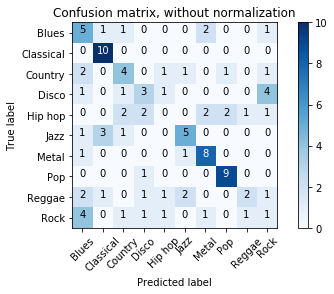

In [42]:
#char, step = char3(15)
from sklearn.metrics import confusion_matrix
import itertools

def mode5(char, step, amount, n_set, gamma):
    hist, char = more_hist(char, step, amount)
    train_mfcc, train_genre, test_mfcc, test_genre = train_test(char, hist, n_set)
    return classify2(train_mfcc, train_genre, test_mfcc, test_genre, gamma)

def classify2(train_mfcc, train_genre, test_mfcc, test_genre, g):
    success=0
    succ_gen = np.zeros(10)
    clf=SVC(kernel = 'linear', gamma=g)
    clf.fit(train_mfcc,train_genre)
    '''for i in range(100):
        test=test_mfcc[i].reshape(1, -1)
        pred = clf.predict(test)
        if pred[0]==test_genre[i]:
            succ_gen[test_genre[i]] += 1
            success+=1
    print succ_gen, np.mean(succ_gen), success
    return success'''
    y_pred = clf.predict(test_mfcc)
    cnf_matrix = confusion_matrix(test_genre, y_pred)
    return cnf_matrix

def classify_mat(train_mfcc, train_genre, test_mfcc, test_genre, g):
    succ_gen = np.zeros((10,10))
    clf=SVC(kernel = 'linear', C=g)
    clf.fit(train_mfcc,train_genre)
    for i in range(100):
        test=test_mfcc[i].reshape(1, -1)
        pred = clf.predict(test)        
        succ_gen[test_genre[i]][pred[0]]+=1
    for i in succ_gen:
        for j in i:
            print "%2.0f" % j,
        print
    #return success

'''for i in range(-3,2):
    print "gamma:", 10**i'''

#cnf_matrix = mode5(char15, (step15*100)/90, amount=90, n_set=9, gamma=1.4)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
cnf_matrix = np.array([[5,1,1,0,0,0,2,0,0,1],[0,10,0,0,0,0,0,0,0,0],[2,0,4,0,1,1,0,1,0,1],[1,0,1,3,1,0,0,0,0,4],[0,0,2,2,0,0,2,2,1,1],
              [1,3,1,0,0,5,0,0,0,0],[1,0,0,0,0,1,8,0,0,0],[0,0,0,1,0,0,0,9,0,0],[2,1,0,1,1,2,0,0,2,1],[4,0,1,1,1,0,1,0,1,1]])

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Blues", "Classical", "Country", "Disco", "Hip hop", "Jazz", "Metal", "Pop",
                                           "Reggae", "Rock",],
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
#char, step = char3(15)

char=char15
step=(step15*100)/90
amount=90
n_set=9
hist, char = more_hist(char, step, amount)
pca=PCA(n_components = 100, svd_solver='auto')
pca.fit(char)
mfcc=pca.transform(char)
for i in range(len(char)):
    char[i]=mfcc[i]
    hist[i]=(mfcc[i],hist[i][1])
train_mfcc, train_genre, test_mfcc, test_genre = train_test(char, hist, n_set)
for i in range(-15,5):
    print "gamma:", 10**i
    gamma=10**i
    print classify2(train_mfcc, train_genre, test_mfcc, test_genre, gamma)
'''for j in range(10):
    print "set:", j
    for i in range(87,93):
        print str(i),":",'''

In [148]:
#leave one out
from sklearn.model_selection import LeaveOneOut
hist, char2 = more_hist(char15, step15, 90)

loo = LeaveOneOut()
loo.get_n_splits(char2)

i = 0
success = 0

for train_index, test_index in loo.split(char2):
    X_train = np.array([char2[j] for j in train_index])
    X_test = np.array([char2[j] for j in test_index])
    y_train  = np.array([hist[j][1] for j in train_index])
    y_test = np.array([hist[j][1] for j in test_index])
    clf=SVC(kernel = 'rbf', gamma=1.4)
    clf.fit(X_train,y_train)
    test=X_test.reshape(1, -1)
    pred = clf.predict(X_test)
    if pred[0]==y_test:
        success+=1
    if i%10==0:
        print str(i),
    i+=1

print success

 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 683


Feature ranking:
1. feature 3 (0.011840)
2. feature 0 (0.011585)
3. feature 0 (0.010474)
4. feature 3 (0.010153)
5. feature 1 (0.010096)
6. feature 8 (0.010084)
7. feature 0 (0.009707)
8. feature 10 (0.009629)
9. feature 2 (0.009549)
10. feature 1 (0.009488)
11. feature 2 (0.009082)
12. feature 0 (0.008644)
13. feature 3 (0.008399)
14. feature 3 (0.008375)
15. feature 11 (0.008210)
16. feature 9 (0.008207)
17. feature 0 (0.008100)
18. feature 0 (0.008054)
19. feature 0 (0.007974)
20. feature 1 (0.007854)
21. feature 7 (0.007851)
22. feature 2 (0.007696)
23. feature 2 (0.007666)
24. feature 3 (0.007388)
25. feature 1 (0.007354)
26. feature 1 (0.007262)
27. feature 12 (0.007104)
28. feature 11 (0.006970)
29. feature 10 (0.006937)
30. feature 11 (0.006929)
31. feature 4 (0.006915)
32. feature 8 (0.006879)
33. feature 3 (0.006853)
34. feature 0 (0.006804)
35. feature 7 (0.006757)
36. feature 3 (0.006652)
37. feature 0 (0.006587)
38. feature 5 (0.006580)
39. feature 10 (0.006537)
40. featur

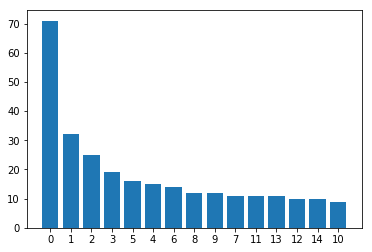

In [17]:
#ExtraTrees
import numpy as np
import matplotlib.pyplot as plt
import operator

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

def mode6(char, step, amount, n_set):
    hist, char = more_hist(char, step, amount)
    train_mfcc, train_genre, test_mfcc, test_genre = train_test(char, hist, n_set)
    return classify3(train_mfcc, train_genre, test_mfcc, test_genre)

def classify3(train_mfcc, train_genre, test_mfcc, test_genre):
    value = dict([(key, 0) for key in range(15)])
    order = dict([(key, 0) for key in range(15)])
    forest = ExtraTreesClassifier()
    forest.fit(train_mfcc,train_genre)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    # Print the feature ranking
    print("Feature ranking:")

    for f in range(train_mfcc.shape[1]):
        #print("%d. feature %d (%f)" % (f + 1, indices[f]/90, importances[indices[f]]))
        if not importances[indices[f]]<=10**-10:
            print("%d. feature %d (%f)" % (f + 1, indices[f]/90, importances[indices[f]]))
            value[indices[f]/90] +=  1
        else:
            break
    
    value = sorted(value.items(), key=operator.itemgetter(1), reverse=True)
    
    return value

    # Plot the feature importances of the forest
    '''plt.figure()
    plt.title("Feature importances")
    plt.bar(range(100), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(100), indices)
    plt.xlim([-1, 10])
    plt.show()'''

value = mode6(char15, (step15*100)/90, amount=90, n_set=4)
print value

feature = zip(*value)[0]
val = zip(*value)[1]
x_pos = np.arange(len(feature))
print feature
print val
plt.bar(x_pos, val ,align='center')
plt.xticks(x_pos, feature) 
plt.show()

In [138]:
#Naive-Bayes
from sklearn.naive_bayes import GaussianNB

def mode7(char, step, amount, n_set):
    hist, char = more_hist(char, step, amount)
    train_mfcc, train_genre, test_mfcc, test_genre = train_test(char, hist, n_set)
    return classify4(train_mfcc, train_genre, test_mfcc, test_genre)

def classify4(train_mfcc, train_genre, test_mfcc, test_genre):
    success=0
    succ_gen = np.zeros(10)
    gnb = GaussianNB()
    y_pred = gnb.fit(train_mfcc,train_genre).predict(test_mfcc)
    #print test_genre == y_pred
    print("Number of mislabeled points out of a total %d points : %d"
      % (test_mfcc.shape[0],(test_genre != y_pred).sum()))

mode7(char15, (step15*100)/90, amount=90, n_set=4)

Number of mislabeled points out of a total 100 points : 56


In [146]:
#AdaBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

def mode8(char, step, amount, n_set):
    hist, char = more_hist(char, step, amount)
    train_mfcc, train_genre, test_mfcc, test_genre = train_test(char, hist, n_set)
    return classify5(train_mfcc, train_genre, test_mfcc, test_genre)

def classify5(train_mfcc, train_genre, test_mfcc, test_genre):
    clf = AdaBoostClassifier()
    scores = cross_val_score(clf, train_mfcc, train_genre)
    print scores.mean()

mode8(char15, (step15*100)/90, amount=90, n_set=4)  

0.1844444444444444
